<a href="https://colab.research.google.com/github/manu49/BayesianNeuralNets/blob/master/StabilisingPriorsVarianceAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self stabilising priors for robust Bayesian deep learning

The accompanying paper 
* arxiv

This notebook is very similar to repository is based on SVDO because they did a great job for an interpretable version and 

<img src="intuition.png" />

### Installation and to run on google colab  


In [1]:
# Logger
!pip install tabulate -q
#from google.colab import files
#src = list(files.upload().values())[0]
#open('logger.py','wb').write(src)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Making the logger in python 

In [3]:
import os
import sys
import random
import numpy as np

from collections import OrderedDict
from tabulate import tabulate
from pandas import DataFrame
from time import gmtime, strftime

In [4]:
## The Logger generates the csv files and stores in a directory called 'logs'

class Logger:
    def __init__(self, directory='logs', name='name', fmt=None):
        self.handler = True
        self.scalar_metrics = OrderedDict()
        self.fmt = fmt if fmt else dict()

        base = '/content/' + directory
        if not os.path.exists(base):
            os.mkdir(base)

        time = gmtime()
        hash = ''.join([chr(random.randint(97, 122)) for _ in range(3)])  # random incase times calsh
        self.path = '%s/%s-%s-%s' % (base, name, hash, strftime('%m-%d-%H:%M', time))

        self.logs = self.path + '.csv'
        self.output = self.path + '.out'
        self.checkpoint = self.path + '.cpt'

        def prin(*args):
            str_to_write = ' '.join(map(str, args))
            with open(self.output, 'a') as f:
                f.write(str_to_write + '\n')
                f.flush()

            print(str_to_write)
            sys.stdout.flush()

        self.print = prin

    def add_scalar(self, t, key, value):
        if key not in self.scalar_metrics:
            self.scalar_metrics[key] = []
        self.scalar_metrics[key] += [(t, value)]

    def iter_info(self, order=None):
        names = list(self.scalar_metrics.keys())
        if order:
            names = order
        values = [self.scalar_metrics[name][-1][1] for name in names]
        t = int(np.max([self.scalar_metrics[name][-1][0] for name in names]))
        fmt = ['%s'] + [self.fmt[name] if name in self.fmt else '.2f' for name in names]

        if self.handler:
            self.handler = False
            self.print(tabulate([[t] + values], ['step'] + names, floatfmt=fmt))
        else:
            self.print(tabulate([[t] + values], ['step'] + names, tablefmt='plain', floatfmt=fmt).split('\n')[1])

    def save(self):
        result = None
        for key in self.scalar_metrics.keys():
            if result is None:
                result = DataFrame(self.scalar_metrics[key], columns=['t', key]).set_index('t')
            else:
                df = DataFrame(self.scalar_metrics[key], columns=['t', key]).set_index('t')
                result = result.join(df, how='outer')
        result.to_csv(self.logs)
        self.print('The log/output have been saved to: ' + self.path + ' + .csv/.out/')

# Implementation

In [5]:
import math
import torch
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import Parameter
from torchvision import datasets, transforms

In [6]:
device = 'cpu'
if torch.cuda.is_available():
    use_cuda = True
    device = 'cuda'

In [7]:
# hyperparameters
width = 256
input_shape = 28*28 ##Because we are using MNIST dataset
output_size = 10
batch_size = 100
init_var = 0.001

n_samples = 20
kl_weight = 1.0
epochs = 10

grad_var = True
forward_var = True

## Proposed self stabilising layer for Bayesian Neural Network
The main difference between this layer and a normal Bayesian layer is the update prior function and the KL term usually added to the loss funciton has become a cross entropy term

In [8]:
class SelfStabilisingLayer(nn.Module):
    '''
    Iteratively updating self stabilising prior.
    Assumptions:
    1. Fully factorised Gaussian priors and posteriors.
    2. Local reparametrisation trick.
    '''

    def __init__(self, in_features, out_features, init_var=0.001, prior_var=0.02):
        super(SelfStabilisingLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.W = Parameter(torch.Tensor(out_features, in_features))
        self.log_sigma = Parameter(torch.Tensor(out_features, in_features))
        self.bias = Parameter(torch.Tensor(1, out_features))

        # initialisation values of parameters
        self.init_var = np.log(init_var)
        self.reset_parameters()

        # stuff to monitor variance
        self.signal_variance = 0
        

    def reset_parameters(self):

        self.log_sigma.data.fill_(self.init_var / 2)
        self.bias.data.zero_()

        # He initialisation
        init = np.sqrt(2 / self.in_features)
        self.W.data.normal_(0, init)
        

    def forward(self, x):

        # local reparametrisation trick with new parameters from q_tilde(W)
        lrt_mean = F.linear(x, self.new_mu) + self.bias
        lrt_std = torch.sqrt(F.linear(x * x, self.new_sigma_sq) + 1e-8)
        eps = lrt_std.data.new(lrt_std.size()).normal_()
        pre_activation = lrt_mean + lrt_std * eps

        if self.training:
            self.signal_variance = pre_activation.var(dim=1)[0].data.cpu().numpy()


        # remove p(w) from the product at test time to observe q(W) approaching true posterior
        if not self.training:
            # Normal LRT
            lrt_mean = F.linear(x, self.W) + self.bias
            lrt_std = torch.sqrt(F.linear(x * x, torch.exp(self.log_sigma * 2.0)) + 1e-8)
            eps = lrt_std.data.new(lrt_std.size()).normal_()
            pre_activation = lrt_mean + lrt_std * eps

        return pre_activation
    

    def update_prior(self):

        # Sum of all incoming nodes to specific hidden units
        muL = torch.sum(self.W, dim=1)
        sig_sq_L = torch.sum(torch.exp(self.log_sigma * 2.0), dim=1)

        # PRIOR VARIANCE
        self.prior_var = ((2 - muL * muL) * sig_sq_L / (muL * muL + sig_sq_L - 2))
        self.prior_var = self.prior_var / self.in_features
        self.prior_var = self.prior_var.expand(self.in_features, self.prior_var.shape[0]).t()
        self.prior_var = torch.abs(self.prior_var)

        # PRIOR MEAN (mean preserving)
        self.prior_mean = self.W

        # PRODUCT, set the parameters from which we will be sampling q_tilde(W)
        self.new_mu, self.new_sigma_sq = multipy_gaussian(self.W, self.prior_mean, 
                                                            torch.exp(self.log_sigma * 2.0), self.prior_var)

        
    def kl_reg(self):

        # cross entropy term
        sigma_sq = torch.exp(self.log_sigma.view(-1) * 2)
        new_sigma_sq = torch.exp(self.new_sigma_sq.view(-1))
        pi = math.pi

        H = 0.5 * torch.log(2 * pi * sigma_sq) + (new_sigma_sq / sigma_sq)
        H = torch.sum(H)

        return H


## Normal Bayesian Neural Network layer
Non-conjugate Gaussian prior and Gaussian posterior as in (Titsias 2014) : http://proceedings.mlr.press/v32/titsias14.html

In [9]:
class LocalReparametrisationLayer(nn.Module):
    '''
    Doubly stochastic Variational Bayes for non-conjugate inference.
    Fully factorised Gaussian priors and posteriors.
    Local reparametrisation trick.
    '''

    def __init__(self, in_features, out_features, bias=True, init_var=0.001, prior_var=0.001):
        super(LocalReparametrisationLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.W = Parameter(torch.Tensor(out_features, in_features))
        self.log_sigma = Parameter(torch.Tensor(out_features, in_features))
        self.bias = Parameter(torch.Tensor(1, out_features))

        # add priors 
        self.prior_mean = torch.Tensor([0]).to(device)
        self.prior_var = torch.Tensor([prior_var]).to(device)

        # initialisation values of parameters
        self.init_var = np.log(init_var)
        self.reset_parameters()

        # stuff to monitor variance
        self.signal_variance = 0

    def reset_parameters(self):

        self.log_sigma.data.fill_(self.init_var / 2)
        self.bias.data.zero_()

        # critical initialisation for normal Bayesian Neural networks
        init = np.sqrt(np.abs((2 - self.in_features * np.exp(self.init_var)) / self.in_features))
        self.W.data.normal_(0, init)

    def forward(self, x):

        # local reparametrisation trick 
        lrt_mean = F.linear(x, self.W) + self.bias
        lrt_std = torch.sqrt(F.linear(x * x, torch.exp(self.log_sigma * 2.0)) + 1e-8)
        eps = lrt_std.data.new(lrt_std.size()).normal_()
        pre_activation = lrt_mean + lrt_std * eps

        if self.training:
            self.signal_variance = pre_activation.var(dim=1)[0].data.cpu().numpy()          

        return pre_activation
    
    def kl_reg(self):

        # KL divergence 
        mean = self.W.view(-1)
        sigma = torch.exp(self.log_sigma).view(-1)

        prior_sigma = torch.sqrt(self.prior_var).view(-1)
        prior_mean = self.prior_mean.view(-1)

        p = torch.distributions.normal.Normal(prior_mean, prior_sigma)
        q = torch.distributions.normal.Normal(mean, sigma)

        kl = torch.distributions.kl.kl_divergence(q, p)

        kl = torch.sum(kl)
        return kl

In [10]:
class FlipoutLayer(nn.Module):
    '''
    (1) the perturbations of different weights are independent
    (2) the perturbation distribution is symmetric around zero.
    Variational Inference by perturbing the weights
    Multiplicative Gaussian perturbations.
    Using ReLU Activation
    Local reparametrisation trick (https://papers.nips.cc/paper/5666-variational-dropout-and-the-local-reparameterization-trick.pdf).
    '''


    '''
    The default layer in TensorFlow Probability

    tfp.layers.DenseFlipout(
    units, activation=None, activity_regularizer=None, trainable=True,
    kernel_posterior_fn=tfp_layers_util.default_mean_field_normal_fn(),
    kernel_posterior_tensor_fn=(lambda d: d.sample()),
    kernel_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p)), bias_pos
    terior_fn=tfp_layers_util.default_mean_field_normal_fn(is_singular=True),
    bias_posterior_tensor_fn=(lambda d: d.sample()), bias_prior_fn=None,
    bias_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p)), seed=None, **kwargs)
    '''

    def __init__(self, in_features, out_features, bias=True, init_var=0.05, prior_var=0.02):
        super(ReparametrisationLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.W = Parameter(torch.Tensor(out_features, in_features))
        self.log_sigma = Parameter(torch.Tensor(out_features, in_features))
        self.bias = Parameter(torch.Tensor(1, out_features))

        # add priors for Gaussian version
        self.prior_mean = torch.Tensor([0]).to(device)
        self.prior_var = torch.Tensor([prior_var]).to(device)

        # initialisation values of parameters
        self.init_var = np.log(init_var)
        self.reset_parameters()

        # stuff to monitor variance
        self.signal_variance = 0

    def reset_parameters(self):
        self.log_sigma.data.fill_(self.init_var / 2)
        self.bias.data.zero_()

        # initialisation to arnus
        init = calculate_init_var(self.in_features, self.init_var, 2)
        self.W.data.normal_(0, init)

    def forward(self, x):

        # sample standard normal
        eps = self.log_sigma.data.new(self.log_sigma.size()).normal_()

        size = W.size()
        r = zeros(size[1])
        s = zeros(size[1])
        i = 0
        while (i<size[1]):
          r[i] = random.uniform(-1.0,1.0)
          s[i] = random.unifrom(-1.0,1.0)
          i = i + 1
          
        # sample weight
        ##weight = self.W + torch.exp(self.log_sigma) * eps
        weight = self.W + torch.exp(self.log_sigma) * eps
        

        # get preactivation
        ##pre_activation = F.linear(x, weight) + self.bias
        pre_activation = F.linear(x, weight) + self.bias

        # monitor variance
        if not self.training:
            self.signal_variance = pre_activation.var(dim=1)[0].data.cpu().numpy()

        return pre_activation

    def kl_reg(self):

        # KL divergence according to Bayes by Backprop
        # take the probs of sampled weights gien their parameters

        # some take the mean?
        # some scale by batch size?
        # some add beta parameter to just reduce KL contribution

        # get all variational posteriors

        mean = self.W.view(-1)
        sigma = torch.exp(self.log_sigma).view(-1)

        prior_sigma = torch.sqrt(self.prior_var)
        prior_mean = self.prior_mean

        # ARD
        #var_eps = (self.W * self.W + sigma_sq)
        # VARIANCE MOTIVATED
        #var_eps = (2 / (self.W * self.W + sigma_sq)) / self.in_features
        #var_eps = (2 / (self.W * self.W + sigma_sq))
        #prior_var = var_eps.view(-1)

        p = torch.distributions.normal.Normal(prior_mean, prior_sigma)
        q = torch.distributions.normal.Normal(mean, sigma)

        kl = torch.distributions.kl.kl_divergence(q, p)

        kl = torch.sum(kl)
        return kl

### Generic ReLU network architecture where we specify the type of layers

In [11]:
# Define a simple fully connected ReLU Network
## The layer types can be LocalReparameterisation, Self-stabilising, Flipout etc.
## This forms a Neural Network with fully connected layers and ReLU activation function
class Net(nn.Module):
    def __init__(self, layer_type, input_size, width=256, init_var=0.001):
        super(Net, self).__init__()
        self.fc_in = layer_type(input_size, width, init_var=init_var)
        self.fc_h1 = layer_type(width, width, init_var=init_var)
        self.fc_h2 = layer_type(width, width, init_var=init_var)
        self.fc_h3 = layer_type(width, width, init_var=init_var)
        self.fc_out = layer_type(width,  output_size, init_var=init_var)

    def forward(self, x):
        x = F.relu(self.fc_in(x))
        x = F.relu(self.fc_h1(x))
        x = F.relu(self.fc_h2(x))
        x = F.relu(self.fc_h3(x))
        x = F.log_softmax(self.fc_out(x), dim=1)
        return x
    
    
    def update_priors(self):
        if hasattr(self.fc_h1, 'update_prior'):
            self.fc_in.update_prior()
            self.fc_out.update_prior()
            self.fc_h1.update_prior()
            self.fc_h2.update_prior()
            self.fc_h3.update_prior()


### Loss function

In [12]:
# Define New Loss Function -- SGVLB 
class SGVLB(nn.Module):
    def __init__(self, net, train_size, batch_size):
        super(SGVLB, self).__init__()
        self.train_size = train_size
        self.batch_size = batch_size
        self.num_batches = train_size / batch_size
        self.net = net

    def forward(self, output, target, kl_weight=1.0):
        assert not target.requires_grad
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()
        kl = kl / self.num_batches
        kl = kl / (self.batch_size*self.train_size)
        kl = kl_weight * kl
        return F.nll_loss(output, target, reduction='sum') + kl

In [13]:
# Load a dataset
def get_mnist(batch_size):
    trsnform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

def get_cifar10(batch_size):
    trsnform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../cifar_data', train=True, download=True,
                         transform=trsnform), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../cifar_data', train=False, download=True,
                         transform=trsnform), batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

In [14]:
def multipy_gaussian(mean1, mean2, var1, var2):

    # calculate variance
    new_var = 1 / ((1 / var1) + (1 / var2)) ##harmonic mean

    # calculate mean
    new_mu = new_var * (mean2 / var2 + mean1 / var1)

    return new_mu, new_var

## Training loop
It just looks a bit crazy because we are tracking and logging quite a few metrics

In [15]:
# training loop with logging
def train(model, epochs, logger):
    
    for epoch in range(1, epochs + 1):

        model.train() 
        train_loss, train_acc = 0, 0

        for batch_idx, (data, target) in enumerate(train_loader):

            #####################################################################
            # Training
            #####################################################################

            optimizer.zero_grad()
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data = data.view(-1, input_shape)

            # update priors
            model.update_priors()

            # forward prop
            output = model(data)
            pred = output.data.max(1)[1]

            # backprop
            loss = loss_fn(output, target, kl_weight)
            loss.backward(retain_graph=True)
            optimizer.step()

            # training loss and accuracy
            train_loss += loss.item()
            train_acc += torch.sum(pred.eq(target))

        #####################################################################
        # Evaluate on test set
        #####################################################################
        model.eval()

        test_loss, avg_test_acc, total_brier = 0, 0, 0
        total_90, total_70, total_50 = 0, 0, 0
        for tbatch_idx, (data, target) in enumerate(test_loader):
            # prep
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data = data.view(-1, input_shape)

            # average over weights with samples of different parameters
            probs, test_loss = 0, 0
            for i in range(n_samples):
                output = model(data)
                probs += output.data
                test_loss += float(loss_fn(output, target).item())
            mean_probs = probs / n_samples
            avg_test_loss = test_loss / n_samples
            pred = torch.argmax(mean_probs, dim=1)
            avg_test_acc += torch.sum(pred == target)
        
        #####################################################################
        # Logging
        #####################################################################
        # log training and test loss and accuracy
        logger.add_scalar(epoch, 'trlos', train_loss)
        logger.add_scalar(epoch, 'telos', avg_test_loss)

        logger.add_scalar(epoch, 'tracc', (float(train_acc) / (batch_size * (batch_idx + 1)) * 100))
        logger.add_scalar(epoch, 'teacc', float(avg_test_acc) / len(test_loader.dataset) * 100)

        logger.iter_info()
    logger.save()

# Experiment 1
## A very simple example on MNIST to demonstrate accelerated training

In [16]:
width = 512
init_var = 0.01
epochs = 10
input_shape = 28*28 ## because we are using MNIST

In [17]:
model = Net(LocalReparametrisationLayer, input_shape, width=width, init_var=init_var)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
logger = Logger(name='LRTNet', directory='demo')

train_loader, test_loader = get_mnist(batch_size=batch_size)
loss_fn = SGVLB(model, len(train_loader.dataset), batch_size)

if device == 'cuda':
    model.cuda()
    
train(model, epochs, logger)
#/content/demo

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.



  step      trlos    telos    tracc    teacc
------  ---------  -------  -------  -------
     1  195044.84   159.06    21.41    39.97
     2  83888.06    67.61    48.29    72.37
     3  43356.36    41.67    75.23    92.08
     4  21663.30    44.60    90.42    94.14
     5  16298.16    28.16    92.82    94.92
     6  14164.18    12.91    93.77    95.36
     7  12286.73    28.22    94.44    95.70
     8  10952.79    26.01    94.94    95.86
     9  9697.48    21.56    95.53    96.11
    10  8836.37    20.18    95.88    96.50
The log/output have been saved to: /content/demo/LRTNet-fjn-06-28-17:13 + .csv/.out/


In [18]:
model = Net(SelfStabilisingLayer, input_shape, width=width, init_var=init_var)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
logger = Logger(name='StabilisedNet', directory='demo')

train_loader, test_loader = get_mnist(batch_size=batch_size)
loss_fn = SGVLB(model, len(train_loader.dataset), batch_size)

if device == 'cuda':
    model.cuda()
    
train(model, epochs, logger)

  step     trlos    telos    tracc    teacc
------  --------  -------  -------  -------
     1  35705.29   311.58    82.53    92.33
     2  13533.88   130.89    93.64    95.30
     3  9643.14    63.59    95.42    96.48
     4  7629.83    65.38    96.40    96.97
     5  6296.26    27.32    97.06    97.31
     6  5233.73    29.79    97.43    97.33
     7  4409.64    19.09    97.89    97.44
     8  4027.59     9.31    98.12    97.67
     9  3503.09    12.60    98.33    97.79
    10  3070.30     8.48    98.52    97.66
The log/output have been saved to: /content/demo/StabilisedNet-aqm-06-28-17:18 + .csv/.out/


### Plot signal propagation dynamics
We suppose the advantages discussed above to be a result of cleaner signals and gradients being propagated through the network. To establish this we monitor the variance dynamics of the same data point throughout training. We calculate the empirical variance of the vector at the pre-activation at each layer during a forward pass shown in figure \ref{variance} (a). It illustrates that our prior encourages more stable signal propagation throughout training. We can infer from unstable variance dynamics shown for a standard BNNs that they have a tendency to lose the signal in deeper and more noisy settings due to exploding or vanishing signals. %In practice, however, we see that when left unregularised the variance dynamics start to deteriorate. 
Similarly, for the backward pass, we evaluate the variance of the gradient of the same signal at the pre-activation shown in \ref{variance} (b). % differentaite between Kingma?
We observe more stable variance or less gradient variance over the same signal over different epochs, i.e. the same signal will have a similar gradient regardless at what stage of training the network is. The more consistent gradient accelerates and improves training.

In [19]:
import matplotlib.pyplot as plt

def plot_variance(df, df2, ymin=0, ymax=20):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    #fig.suptitle('High init var 20 layers deep 256 wide', fontsize=16)
    # train and test accuracy and loss
    df.T.plot(ax=axes[0]).set_title("With stabilising prior")
    df2.T.plot(ax=axes[1]).set_title("Normal BNN")
    axes[0].set_ylim([ymin,ymax])
    axes[1].set_ylim([ymin,ymax])
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    
    axes[0].set_ylabel('Variance at pre-activation')
    axes[0].set_xlabel('Layer ($l$)')

    plt.show()
    
def plot_performance(df, df2, ymin=0, ymax=100):

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    # train and test accuracy and loss
    df['teacc'].plot(ax=axes[0,0]).set_title("Test accuracy")
    df2[['teacc']].plot(ax=axes[0,0]).legend(["NormalBNN", "StabilisingPrior"])
    df[['tracc']].plot(ax=axes[1,0]).set_title("Training accuracy")
    df2[['tracc']].plot(ax=axes[1,0]).legend(["NormalBNN", "StabilisingPrior"])
    axes[0,0].set_ylim([ymin,ymax])
    axes[1,0].set_ylim([ymin,ymax])

    df[['telos']].plot(ax=axes[0,1]).set_title("Test loss")
    df2[['telos']].plot(ax=axes[0,1]).legend(["NormalBNN", "StabilisingPrior"])

    df[['trlos']].plot(ax=axes[1,1]).set_title("Train loss")
    df2[['trlos']].plot(ax=axes[1,1]).legend(["NormalBNN", "StabilisingPrior"])

    plt.show()

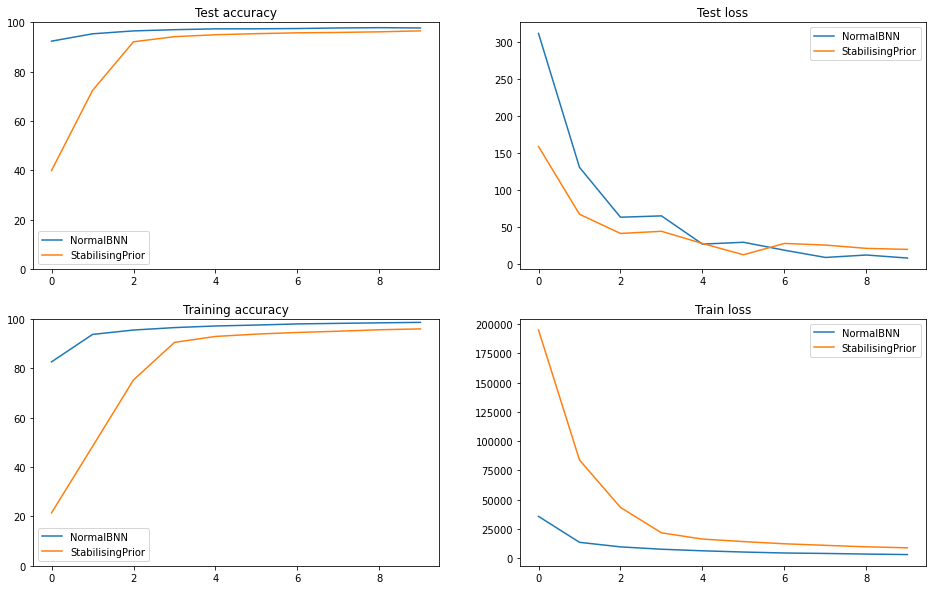

In [20]:
import glob

filename1, filename2 = glob.glob('/content/demo/*.csv')
df = pd.read_csv(filename1)
df2 = pd.read_csv(filename2)   
plot_performance(df,df2)

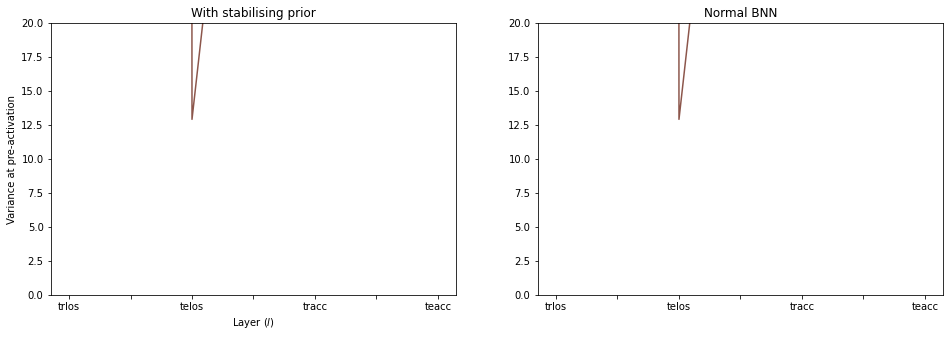

In [21]:
filename1 = '/content/demo/LRTNet-fjn-06-28-17:13.csv'
df = pd.read_csv(filename1, index_col=0)
filename2 = '/content/demo/StabilisedNet-aqm-06-28-17:18.csv'
df2 = pd.read_csv(filename1, index_col=0)
plot_variance(df, df2)

# Experiment 2
### Evaluate uncertainty quality and combine our stabilising prior with a regularising for better training and calibration
We define a new SelfStabilisingRegularisedLayer and run 3 experiments with different models. This just demonstrates the plug and play interpretation that one can do with priors with the reformulated ELBO objective we showed in the paper. As we will see any model with a prior that iteratively updates its hyperparameters can overfit, but we can combine a regularising prior with an optimal prior. We also observe that combining the stabilising prior with Empirical Bayes prior improves training. Here we just stick a stabilising and regularising combo. (MNIST is too easy so we do this on CIFAR-10)

### Layer that is self stabilising and regularised
We include the stabilising prior on the forward pass and add regularising prior to the loss function

In [22]:
def to_one_hot(y, n_dims=None):
    y_tensor = y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return y_one_hot

def compute_brier_score(softmax_probs, true_labels):

    if not isinstance(true_labels, torch.FloatTensor) and not isinstance(true_labels, torch.DoubleTensor):
        true_labels = true_labels.float()

    se = torch.sum((true_labels - softmax_probs)**2)
    t = torch.sum(se)
    score = torch.mean(t, dim=0)
    return score

In [45]:
class StabilisingRegularisedLayer(nn.Module):
    '''
    Iteratively updating self stabilising prior.
    Fully factorised Gaussian priors and posteriors.
    Local reparametrisation trick.
    '''

    def __init__(self, in_features, out_features, init_var=0.001, prior_var=0.001):
        super(StabilisingRegularisedLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.W = Parameter(torch.Tensor(out_features, in_features))
        self.log_sigma = Parameter(torch.Tensor(out_features, in_features))
        self.bias = Parameter(torch.Tensor(1, out_features))

        # initialisation values of parameters
        self.init_var = np.log(init_var)
        self.reset_parameters()
        
        # add priors 
        self.regularising_prior_mean = torch.Tensor([0]).to(device)
        self.regularising_prior_var = torch.Tensor([prior_var]).to(device)

        # stuff to monitor variance
        self.signal_variance = 0

    def reset_parameters(self):

        self.log_sigma.data.fill_(self.init_var / 2)
        self.bias.data.zero_()

        # He initialisation
        init = np.sqrt(2 / self.in_features)
        self.W.data.normal_(0, init)

    def forward(self, x):

        # local reparametrisation trick with new parameters from q_tilde(W)
        lrt_mean = F.linear(x, self.new_mu) + self.bias
        lrt_std = torch.sqrt(F.linear(x * x, self.new_sigma_sq) + 1e-8)
        eps = lrt_std.data.new(lrt_std.size()).normal_()
        pre_activation = lrt_mean + lrt_std * eps

        if self.training:
            self.signal_variance = pre_activation.var(dim=1)[0].data.cpu().numpy()


        # remove p(w) from the product at test time to observe q(W) approaching true posterior
        if not self.training:
            # Normal LRT
            lrt_mean = F.linear(x, self.W) + self.bias
            lrt_std = torch.sqrt(F.linear(x * x, torch.exp(self.log_sigma * 2.0)) + 1e-8)
            eps = lrt_std.data.new(lrt_std.size()).normal_()
            pre_activation = lrt_mean + lrt_std * eps

        return pre_activation

    def update_prior(self):

        # Sum of all incoming nodes to specific hidden units
        muL = torch.sum(self.W, dim=1)
        sig_sq_L = torch.sum(torch.exp(self.log_sigma * 2.0), dim=1)

        # PRIOR VARIANCE
        self.prior_var = ((2 - muL * muL) * sig_sq_L / (muL * muL + sig_sq_L - 2))
        self.prior_var = self.prior_var / self.in_features
        self.prior_var = self.prior_var.expand(self.in_features, self.prior_var.shape[0]).t()
        self.prior_var = torch.abs(self.prior_var)

        # PRIOR MEAN (mean preserving)
        self.prior_mean = self.W

        # PRODUCT, set the parameters from which we will be sampling q_tilde(W)
        self.new_mu, self.new_sigma_sq = multipy_gaussian(self.W, self.prior_mean, 
                                                            torch.exp(self.log_sigma * 2.0), self.prior_var)


    def kl_reg(self):

        # Cross entropy term 
        sigma_sq = torch.exp(self.log_sigma.view(-1) * 2)
        new_sigma_sq = torch.exp(self.new_sigma_sq.view(-1))
        pi = math.pi

        H = 0.5 * torch.log(2 * pi * sigma_sq) + (new_sigma_sq / sigma_sq)
        H = torch.sum(H)
        
        # KL divergence from regularising prior
        mean = self.W.view(-1)
        sigma = torch.exp(self.log_sigma).view(-1)

        prior_sigma = torch.sqrt(self.regularising_prior_var).view(-1)
        prior_mean = self.regularising_prior_mean.view(-1)

        p = torch.distributions.normal.Normal(prior_mean, prior_sigma)
        q = torch.distributions.normal.Normal(mean, sigma)

        kl = torch.distributions.kl.kl_divergence(q, p)

        kl = torch.sum(kl)

        return H + kl


In [46]:
# training loop with logging
def train(model, epochs, logger):
    if forward_var:
        cols = [i for i in range(5)]
        forward_var_df = pd.DataFrame(columns=cols)
    if grad_var:
        cols = [i for i in range(5)]
        grad_var_df = pd.DataFrame(columns=cols)
    
    for epoch in range(1, epochs + 1):

        model.train() 
        train_loss, train_acc = 0, 0
        number = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            log_name = str(number)+"heyya"
            number = number + 1
            #####################################################################
            # Training
            #####################################################################

            optimizer.zero_grad()
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data = data.view(-1, input_shape)

            # update priors
            model.update_priors()

            # forward prop
            output = model(data)
            pred = output.data.max(1)[1]

            # backprop
            loss = loss_fn(output, target, kl_weight)
            loss.backward(retain_graph=True)
            optimizer.step()

            # training loss and accuracy
            train_loss += loss.item()
            train_acc += torch.sum(pred.eq(target))

            # Track the signal propagation dynamics through the layers through the epochs
            if forward_var:
                # Get the same signal and log its variance throughout training
                # Choose specific batch id so its the same signal
                var = []
                if batch_idx == 10:
                    for i, c in enumerate(model.children()):
                        if isinstance(c, nn.ModuleList):
                            for j, layer in enumerate(c):
                                # print(layer.signal_variance)
                                var.append(layer.signal_variance)
                    #df3 = pd.concat([df3, data], axis=0)    df3.loc[len(df3)]=data
                    #forward_var_df = pd.concat([forward_var_df,var],axis=0)  # adding a row
                    forward_var_df = forward_var_df.append(var)
                    forward_var_df.index = forward_var_df.index + 1  # shifting index
                    forward_var_df = forward_var_df.sort_index()

                    forward_var_df.to_csv(str('/content/logs/' + log_name + '_forward_var.csv'))

            # Track gradient through the layers through the epochs
            '''if grad_var:
                # when observing variance in gradient with signal prop lense
                # Choose specific batch id so its the same signal
                if batch_idx == 10:
                    grad_var_sig_prop = calculate_signal_prop_var(model, data, target, loss_fn, kl_weight=0)
                    # print(grad_var_sig_prop)
                    #grad_var_df = pd.concat([grad_var_df,grad_var_sig_prop[0]],axis = 0)  # adding a row
                    grad_var_df = grad_var_df.append(grad_var_sig_prop[0])
                    grad_var_df.index = grad_var_df.index + 1  # shifting index
                    grad_var_df = grad_var_df.sort_index()
                    grad_var_df.to_csv(str('/content/logs/' + log_name + '_grad_var.csv'))'''


        #####################################################################
        # Evaluate on test set
        #####################################################################
        model.eval()

        test_loss, avg_test_acc, total_brier = 0, 0, 0
        total_90, total_70, total_50 = 0, 0, 0
        for tbatch_idx, (data, target) in enumerate(test_loader):
            # prep
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data = data.view(-1, input_shape)

            # average over weights with samples of different parameters
            probs, test_loss = 0, 0
            for i in range(n_samples):
                output = model(data)
                probs += output.data
                test_loss += float(loss_fn(output, target).item())
            mean_probs = probs / n_samples
            avg_test_loss = test_loss / n_samples
            pred = torch.argmax(mean_probs, dim=1)
            avg_test_acc += torch.sum(pred == target)

        
            # accuracy of threshold
            preds = torch.exp(mean_probs)
            one_hot_bois = to_one_hot(target).to(device)

            condition = (0.90 < preds)
            #condition = (0.85 > preds) & (0.75 < preds)
            res = torch.sum(torch.round(preds[condition]) == one_hot_bois[condition])
            if float(torch.sum(condition)) != 0:
                total_90 += float(res) / float(torch.sum(condition))
            condition = (0.7 < preds)
            #condition = (0.55 < preds) & (0.65 > preds)
            res = torch.sum(torch.round(preds[condition]) == one_hot_bois[condition])
            if float(torch.sum(condition)) != 0:
                total_70 += float(res) / float(torch.sum(condition))
            condition = (0.5 < preds)
            #condition = (0.55 < preds) & (0.65 > preds)
            res = torch.sum(torch.round(preds[condition]) == one_hot_bois[condition])
            if float(torch.sum(condition)) != 0:
                total_50 += float(res) / float(torch.sum(condition))

            # Brier score
            total_brier += compute_brier_score(one_hot_bois, torch.exp(mean_probs))

        total_brier = (total_brier / len(test_loader)).data
        total_90 = total_90 / len(test_loader)
        total_70 = total_70 / len(test_loader)
        total_50 = total_50 / len(test_loader)
        
        #####################################################################
        # Logging
        #####################################################################
        # log training and test loss and accuracy
        logger.add_scalar(epoch, 'trlos', train_loss)
        logger.add_scalar(epoch, 'telos', avg_test_loss)

        logger.add_scalar(epoch, 'tracc', (float(train_acc) / (batch_size * (batch_idx + 1)) * 100))
        logger.add_scalar(epoch, 'teacc', float(avg_test_acc) / len(test_loader.dataset) * 100)

        logger.add_scalar(epoch, 'brier', total_brier)
        logger.add_scalar(epoch, '90 conf', total_90)
        logger.add_scalar(epoch, '70 conf', total_70)
        logger.add_scalar(epoch, '50 conf', total_50)

        logger.iter_info()
    logger.save()

In [47]:
width = 512
init_var = 0.01
epochs = 100

input_shape = 32 * 32 * 3 ## Because we are using CIFAR-10 Dataset

In [43]:
model = Net(LocalReparametrisationLayer, input_shape, width=width, init_var=init_var)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
logger = Logger(name='CifarLRTNet', directory='demo_cifar')

train_loader, test_loader = get_cifar10(batch_size=batch_size)
loss_fn = SGVLB(model, len(train_loader.dataset), batch_size)

if device == 'cuda':
    model.cuda()
    
train(model, epochs, logger)

Files already downloaded and verified
Files already downloaded and verified
  step      trlos    telos    tracc    teacc    brier    90 conf    70 conf    50 conf
------  ---------  -------  -------  -------  -------  ---------  ---------  ---------
     1  218005.42   236.07    10.75    12.72    89.78       0.00       0.00       0.00
     2  116313.39   232.24    11.94    14.56    89.25       0.00       0.00       0.00
     3  113729.29   222.94    13.67    18.26    87.33       0.00       0.00       0.00
     4  109230.99   213.64    17.27    24.57    83.69       0.00       0.02       0.55
     5  102009.70   193.78    22.87    30.80    80.19       0.01       0.30       0.69
     6  96344.14   200.15    28.00    34.72    77.77       0.06       0.62       0.76
     7  91801.82   173.60    32.24    39.53    74.39       0.30       0.86       0.76
     8  87828.58   183.21    35.99    40.29    72.41       0.56       0.85       0.76
     9  84676.96   167.80    38.79    42.68    71.00     

In [ ]:
model = Net(StabilisingRegularisedLayer, input_shape, width=256, init_var=0.001)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
logger = Logger(name='CifarStabilisedNet', directory='democifar_cifar')

train_loader, test_loader = get_cifar10(batch_size=batch_size)
loss_fn = SGVLB(model, len(train_loader.dataset), batch_size)

if device == 'cuda':
    model.cuda()
    
train(model, epochs, logger)

In [ ]:
model = Net(SelfStabilisingLayer, input_shape, width=256, init_var=0.001)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
logger = Logger(name='StabilisedNetWithoutRegularisation', directory='democifar_cifar')

train_loader, test_loader = get_cifar10(batch_size=batch_size)
loss_fn = SGVLB(model, len(train_loader.dataset), batch_size)

if device == 'cuda':
    model.cuda()
    
train(model, epochs, logger)

In [ ]:
model = Net(FlipoutLayer, input_shape, width=256, init_var=0.001)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
logger = Logger(name='Flipout', directory='democifar_cifar')

train_loader, test_loader = get_cifar10(batch_size=batch_size)
loss_fn = SGVLB(model, len(train_loader.dataset), batch_size)

if device == 'cuda':
    model.cuda()
    
train(model, epochs, logger)

### Plot uncertainty and calibration metrics

In [50]:
def plot_brier(filename1, filename2, filename3, filename4, ymin=0, ymax=100):
    df = pd.read_csv(filename1)
    df2 = pd.read_csv(filename2)
    df3 = pd.read_csv(filename3)
    df4 = pd.read_csv(filename4)


    fig, axes = plt.subplots(1,1,figsize=(5, 5))
    #fig, axes = plt.subplots()
    #fig.suptitle('Progression of test accuracy on through epochs on CIFAR')
    
    # Parse brier score from string
    brir = [i.split('(', 1)[1] for i in df['brier']]
    brir = [float(i.split(',', 1)[0]) for i in brir]
    axes.plot(brir)
    # Parse brier score from string
    brir = [i.split('(', 1)[1] for i in df2['brier']]
    brir = [float(i.split(',', 1)[0]) for i in brir]
    axes.plot(brir)
    # Parse brier score from string
    brir = [i.split('(', 1)[1] for i in df3['brier']]
    brir = [float(i.split(',', 1)[0]) for i in brir]
    axes.plot(brir)
    # Parse brier score from string
    brir = [i.split('(', 1)[1] for i in df4['brier']]
    brir = [float(i.split(',', 1)[0]) for i in brir]
    axes.plot(brir)

    axes.legend(["Standard Gaussian with LRT", "Stabilising Prior with Reg",
                                         "Self Stabilising Prior", "Flipout", 
                                        "Stabilising and Standard Mixture", "EB and StandardMixture"])

    plt.ylabel('Accuracy on examples above threshold')
    plt.xlabel('Epoch')
    #axes.set_ylim([ymin,ymax])
    plt.savefig('Confidence'+str(save_id)+'.pdf')
    plt.show()